# Import libs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cv2

import os
from os import listdir
from os.path import isfile, join, basename, splitext

from random import shuffle

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# 1. Load training images and labels

In [2]:
# get all training image pathes
train_files = []
train_class = []
train_data_folder = 'data/train'
for subfolder in listdir(train_data_folder):
    subfolder_path = join(train_data_folder, subfolder)
    for file in listdir(subfolder_path):
        if(splitext(file)[1] == '.jpg'):
            train_files.append(join(subfolder_path, file))
            train_class.append(subfolder)
        
train_files = np.asarray(train_files)
train_class = np.asarray(train_class)

In [3]:
print(train_files.shape, train_class.shape)

(2985,) (2985,)


In [4]:
train_files[:5]

array(['data/train/opencountry/image_0125.jpg',
       'data/train/opencountry/image_0226.jpg',
       'data/train/opencountry/image_0289.jpg',
       'data/train/opencountry/image_0094.jpg',
       'data/train/opencountry/image_0310.jpg'], 
      dtype='<U38')

In [5]:
train_class[:5]

array(['opencountry', 'opencountry', 'opencountry', 'opencountry',
       'opencountry'], 
      dtype='<U12')

## 1.1 Scale images to same size

In [6]:
image_size = (256, 256) # (width, height)

train_images = []
for f in train_files:
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    resized_image = cv2.resize(img, image_size)
    train_images.append(resized_image)
    
train_images = np.asarray(train_images)

(2985, 256, 256)


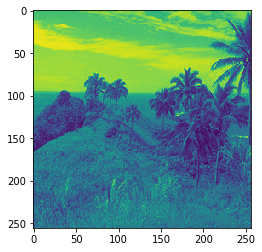

In [7]:
print(train_images.shape)

plt.imshow(train_images[1])
plt.show()

## One-hot encode img class

- CALsuburb, 9
- PARoffice, 7
- bedroom, 12
- coast, 10
- forest, 4
- highway, 14
- industrial, 2
- insidecity, 3
- kitchen, 0
- livingroom, 5
- mountain, 8
- opencountry, 6
- store, 11
- street, 1
- tallbuilding, 13

In [8]:
class_mapping = {'CALsuburb':9, 
                 'PARoffice':7, 
                 'bedroom':12, 
                 'coast':10, 
                 'forest':4, 
                 'highway':14, 
                 'industrial':2, 
                 'insidecity':3, 
                 'kitchen':0, 
                 'livingroom':5, 
                 'mountain':8, 
                 'opencountry':6, 
                 'store':11, 
                 'street':1, 
                 'tallbuilding':13}

train_class_label = pd.Series(train_class).map(class_mapping).as_matrix()
train_class_label

array([6, 6, 6, ..., 7, 7, 7])

In [9]:
train_class_onehot = np.eye(15)[train_class_label]

print(train_class_onehot.shape)
train_class_onehot[:5]

(2985, 15)


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.]])

# Define image batch generator & data augmentation with openCV

In [10]:
def rotate_bound(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2) # image center
 
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)

    return cv2.warpAffine(image, M, (w, h))

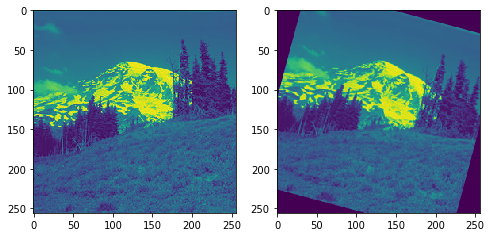

In [11]:
ori_img = train_images[0]
img = rotate_bound(ori_img, 15)

fig=plt.figure(figsize=(8, 8))

fig.add_subplot(1, 2, 1)
plt.imshow(ori_img)
fig.add_subplot(1, 2, 2)
plt.imshow(img)

plt.show()

In [12]:
def ImgBatchGenerator(images, labels, bs, isShuffle=True, doAug=False):
    dataLen = images.shape[0]
    index = list(range(dataLen))
    
    if(isShuffle):
        shuffle(index)
    
    batch_num = int(dataLen / bs)
    for i in range(batch_num):
        batch_index = index[i * bs : (i+1) * bs]
        
        batch_images = images[batch_index]
        batch_labels = labels[batch_index]
        
        if(doAug):
            for i in range(batch_images.shape[0]):
                rand = np.random.choice(2, 1)[0] # 1 for flip
                if(rand == 1): 
                    batch_images[i] = cv2.flip(batch_images[i], 1)
                
                rotate = np.random.choice([0,5,10,-5,-10], 1)[0]
                batch_images[i] = rotate_bound(batch_images[i], rotate)
        
        yield batch_images, batch_labels

## Test generator

[ 9  2 13  4  0]


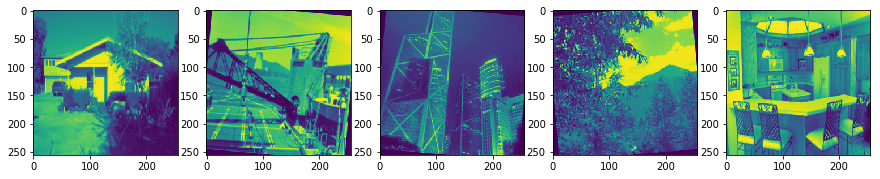

In [13]:
bs = 5
gen = ImgBatchGenerator(train_images, train_class_onehot, bs, doAug=True)
bImg, bLabel = next(gen)


print(np.argmax(bLabel, axis=1))

fig=plt.figure(figsize=(15, 15))
columns = bs
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(bImg[i-1])
plt.show()

# Test Keras ImageDataGenerator()

In [21]:
keras_gen = ImageDataGenerator(rotation_range=15, 
                             width_shift_range=0.1, # fraction of total width
                             height_shift_range=0.1, # fraction of total height
                             horizontal_flip=True, 
                             vertical_flip=False)

(5, 256, 256, 1)


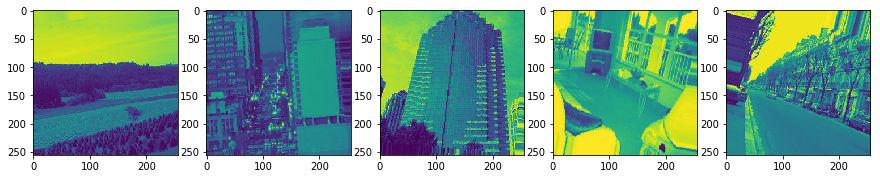

In [23]:
bs=5
fig=plt.figure(figsize=(15, 15))
for x_batch, y_batch in keras_gen.flow(train_images[:,:,:,np.newaxis], train_class_onehot, batch_size=bs):
    print(x_batch.shape)
    for i in range(bs):
        fig.add_subplot(1, bs, i+1)
        plt.imshow(x_batch[i].reshape(image_size))
    plt.show()
    break

# Define classifier

In [24]:
class ImgClassifier:
    def __init__(self, input_w, input_h, output_size):
        
        self.input_width = input_w
        self.input_height = input_h
        self.output_size = output_size
        
        tf.reset_default_graph()
        
        # build CNN model
        self._Build_CNN_clf()
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def Train(self, x, y):
        loss, acc, _ = self.sess.run([self.loss, self.acc, self.train], feed_dict={self.input:x, self.label:y, self.is_training:True})
        return(loss, acc)
        
    def Predict(self, x):
        return self.sess.run(self.predictions['classes'], feed_dict={self.input:x, self.is_training:False})
        
    def Predict_prob(self, x):
        return self.sess.run(self.predictions['probabilities'], feed_dict={self.input:x, self.is_training:False})
        
    def _Build_CNN_clf(self):
        self.is_training = tf.placeholder(dtype=tf.bool, name='is_training')
        
        self.input = tf.placeholder(dtype=tf.float32, shape=(None, self.input_height, self.input_width, 1), name='input')
        self.label = tf.placeholder(dtype=tf.float32, shape=(None, self.output_size), name='label')
        
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.01)
        
        hid_layer_act = tf.nn.selu
        
        h1 = tf.layers.conv2d(inputs=self.input, 
                              filters=16, 
                              kernel_size=(3,3), 
                              kernel_regularizer=regularizer,
                              activation=hid_layer_act, 
                              name='cnv1', 
                              padding='same')
        p1 = tf.layers.max_pooling2d(inputs=h1, pool_size=(2,2), strides=2, name='p1')
        print('p1 shape : ', p1.shape)
        
        h2 = tf.layers.conv2d(inputs=p1, 
                              filters=32, 
                              kernel_size=(3,3),
                              kernel_regularizer=regularizer,
                              activation=hid_layer_act, 
                              name='cnv2', 
                              padding='same')
        p2 = tf.layers.max_pooling2d(inputs=h2, pool_size=(2,2), strides=2, name='p2')
        print('p2 shape : ', p2.shape)
        
        h3 = tf.layers.conv2d(inputs=p2, 
                              filters=64, 
                              kernel_size=(3,3), 
                              kernel_regularizer=regularizer,
                              activation=hid_layer_act, 
                              name='cnv3', 
                              padding='same')
        p3 = tf.layers.max_pooling2d(inputs=h3, pool_size=(2,2), strides=2, name='p3')
        print('p3 shape : ', p3.shape)
        
        h4 = tf.layers.conv2d(inputs=p3, 
                              filters=128,
                              kernel_size=(3,3), 
                              kernel_regularizer=regularizer,
                              activation=hid_layer_act, 
                              name='cnv4', 
                              padding='same')
        p4 = tf.layers.max_pooling2d(inputs=h4, pool_size=(2,2), strides=2, name='p4')
        print('p4 shape : ', p4.shape)
        
        h5 = tf.layers.conv2d(inputs=p4, 
                              filters=256,
                              kernel_size=(3,3),
                              kernel_regularizer=regularizer,
                              activation=hid_layer_act,
                              name='cnv5',
                              padding='same')
        p5 = tf.layers.max_pooling2d(inputs=h5, pool_size=(2,2), strides=2, name='p5')
        print('p5 shape : ', p5.shape)
        
        # flatten
        final_feature_map = p5
        flatten_size = final_feature_map.shape[1] * final_feature_map.shape[2] * final_feature_map.shape[3]
        feature_map_flatten = tf.reshape(final_feature_map, shape=(-1, flatten_size))
        print('feature map flatten : ', feature_map_flatten.shape)
        
        d1 = tf.layers.dense(feature_map_flatten, 
                             units=1024, 
                             kernel_regularizer=regularizer,
                             activation=hid_layer_act, 
                             name='d1')
#         dropout1 = tf.layers.dropout(inputs=d1, rate=0.4, training=self.is_training)
        
        output = tf.layers.dense(d1, units=self.output_size, activation=None, name='output')
    
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.label, logits=output, name='cross_entropy')
        self.loss = tf.reduce_mean(cross_entropy) #+ tf.losses.get_regularization_loss() # add regulerization loss
        
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        self.train = optimizer.minimize(loss=self.loss)
        
        self.predictions = {
              "classes": tf.argmax(input=output, axis=1),
              "probabilities": tf.nn.softmax(output, name="softmax")
          }
        
        equality = tf.equal(self.predictions['classes'], tf.argmax(self.label, axis=1))
        self.acc = tf.reduce_mean(tf.cast(equality, tf.float32))

# Train model

In [25]:
x_train, x_test, y_train, y_test = train_test_split(train_images, train_class_onehot, test_size=0.2, random_state=42)

In [26]:
train_loss_rec, train_acc_rec, val_acc_rec = [], [], []
clf = ImgClassifier(input_w=image_size[0], input_h=image_size[1], output_size=15)

p1 shape :  (?, 128, 128, 16)
p2 shape :  (?, 64, 64, 32)
p3 shape :  (?, 32, 32, 64)
p4 shape :  (?, 16, 16, 128)
p5 shape :  (?, 8, 8, 256)
feature map flatten :  (?, 16384)


In [31]:
batch_size = 100
epoch_size = 30

train_count = 0

datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True, vertical_flip=False)

for epoch in range(epoch_size):
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train[:,:,:,np.newaxis], y_train, batch_size=batch_size):
        loss, acc = clf.Train(x_batch, y_batch)
    
        train_loss_rec.append(loss)
        train_acc_rec.append(acc)
        
        batches += 1
        if batches >= len(x_train) / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
    
    print('epoch {} finish'.format(epoch)) 
    print('train loss : {}, acc : {}'.format(train_loss_rec[-1],train_acc_rec[-1]))
    
    if(x_test.shape[0] > 0):
        pred = clf.Predict(x_test[:, :, :, np.newaxis])
        val_acc = np.mean(np.equal(pred, np.argmax(y_test, axis=1)))
        val_acc_rec.append(val_acc)
        print('test acc : ', val_acc)

epoch 0 finish
train loss : 0.6228432059288025, acc : 0.7045454382896423
test acc :  0.7202680067
epoch 1 finish
train loss : 0.4158753454685211, acc : 0.8409090638160706
test acc :  0.737018425461
epoch 2 finish
train loss : 0.4884362518787384, acc : 0.8181818127632141
test acc :  0.738693467337
epoch 3 finish
train loss : 0.4611498713493347, acc : 0.7954545617103577
test acc :  0.765494137353
epoch 4 finish
train loss : 0.4411521852016449, acc : 0.8295454382896423
test acc :  0.748743718593
epoch 5 finish
train loss : 0.3062027096748352, acc : 0.9204545617103577
test acc :  0.758793969849
epoch 6 finish
train loss : 0.39652156829833984, acc : 0.8409090638160706
test acc :  0.731993299832
epoch 7 finish
train loss : 0.1933513730764389, acc : 0.9318181872367859
test acc :  0.750418760469
epoch 8 finish
train loss : 0.26168787479400635, acc : 0.9090909361839294
test acc :  0.757118927973
epoch 9 finish
train loss : 0.6041126847267151, acc : 0.7727272510528564
test acc :  0.726968174204


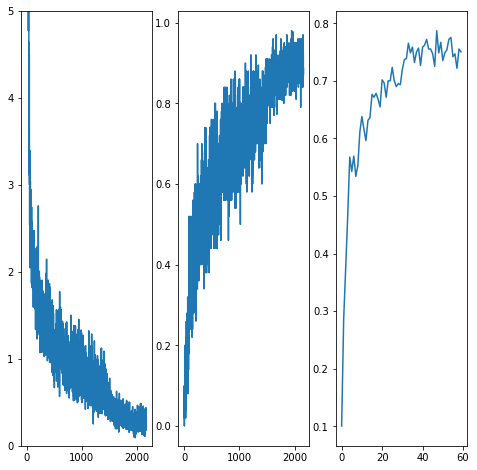

In [33]:
train_step = np.arange(len(train_acc_rec))
val_step = np.arange(len(val_acc_rec))

fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1, 3, 1)
plt.plot(train_step, train_loss_rec)
axes = plt.gca()
axes.set_ylim([0, 5])
fig.add_subplot(1, 3, 2)
plt.plot(train_step, train_acc_rec)
fig.add_subplot(1, 3, 3)
plt.plot(val_step, val_acc_rec)
plt.show()

# Predict testing data

## Load testing data

In [34]:
# load test images
test_data_folder = 'data/testset'

test_files = []
test_file_ids = []

for file in listdir(test_data_folder):
    test_files.append(join(test_data_folder, file))
    test_file_ids.append(splitext(file)[0])

In [35]:
test_files[:5]

['data/testset/72acbd0f4ff70d9862c458894c91964bc91c5ed053f61d5f15708142c5a12b99.jpg',
 'data/testset/38bc001a70dfa9b84878e165a021402cd88296e898db97f8e15edbb787541eee.jpg',
 'data/testset/4afab9f13aabb30d757738eb1af0d7f05c36b3c1260557ce7f5c076345cd1a4e.jpg',
 'data/testset/c1de3ac7f8f40886f8ef4497a802e3d94e2f1a9b981e4a0e419ce8c282048bb8.jpg',
 'data/testset/247048ce77e38284db9538e85fabb6bd78f696c2d16fc96ed81b08b38eff0e7d.jpg']

In [36]:
test_file_ids[:5]

['72acbd0f4ff70d9862c458894c91964bc91c5ed053f61d5f15708142c5a12b99',
 '38bc001a70dfa9b84878e165a021402cd88296e898db97f8e15edbb787541eee',
 '4afab9f13aabb30d757738eb1af0d7f05c36b3c1260557ce7f5c076345cd1a4e',
 'c1de3ac7f8f40886f8ef4497a802e3d94e2f1a9b981e4a0e419ce8c282048bb8',
 '247048ce77e38284db9538e85fabb6bd78f696c2d16fc96ed81b08b38eff0e7d']

In [37]:
test_images = []

for f in test_files:
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    resized_image = cv2.resize(img, image_size)
    test_images.append(resized_image)
    
test_images = np.asarray(test_images)

In [38]:
test_images.shape

(1500, 256, 256)

In [56]:
test_image_ch = test_images[:, :, :, np.newaxis]

bs = 100
bn = int(test_image_ch.shape[0] / bs)

test_pred = np.zeros((test_image_ch.shape[0]), dtype=np.int)

for i in range(bn):
    start_ind = i*bs
    end_ind = (i+1)*bs
    pred = clf.Predict(test_image_ch[start_ind : end_ind])
    test_pred[start_ind : end_ind] = pred
    
# for image in test_image_ch:
#     test_pred.append(clf.Predict(image[np.newaxis]))

In [57]:
test_pred

array([ 8,  9, 10, ...,  9,  2,  1])

In [58]:
df = pd.DataFrame({'id':test_file_ids, 'class':test_pred})

In [59]:
df.head()

,class,id
0,8,72acbd0f4ff70d9862c458894c91964bc91c5ed053f61d...
1,9,38bc001a70dfa9b84878e165a021402cd88296e898db97...
2,10,4afab9f13aabb30d757738eb1af0d7f05c36b3c1260557...
3,3,c1de3ac7f8f40886f8ef4497a802e3d94e2f1a9b981e4a...
4,5,247048ce77e38284db9538e85fabb6bd78f696c2d16fc9...


In [60]:
df[['id', 'class']].to_csv('test_pred.csv', index=False)